# Load Dataset

In [1]:
import pandas as pd

# load the dataset
df = pd.read_csv('M_metadata_v1.csv')

rs = 42

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Cast 1        799 non-null    object
 1   Cast 2        799 non-null    object
 2   Cast 3        799 non-null    object
 3   Cast 4        799 non-null    object
 4   Cast 5        799 non-null    object
 5   Cast 6        799 non-null    object
 6   Description   799 non-null    object
 7   Director 1    799 non-null    object
 8   Director 2    799 non-null    object
 9   Director 3    799 non-null    object
 10  Genre         799 non-null    object
 11  Rating        799 non-null    object
 12  Release Date  799 non-null    object
 13  Runtime       799 non-null    object
 14  Studio        799 non-null    object
 15  Title         799 non-null    object
 16  Writer 1      799 non-null    object
 17  Writer 2      799 non-null    object
 18  Writer 3      799 non-null    object
 19  Writer 4

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [44]:
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
stopwords = set(['2','avp','100','000','3','4','official','film','one','two','three','four']).union(set(sw.words('english')))


In [45]:
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [46]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            if token in stopwords:
                continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list]

            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Description'])

print(len(tfidf_vec.get_feature_names_out()))

64895


In [48]:
from sklearn.cluster import KMeans

# K means clustering using the term vector
kmeans = KMeans(n_clusters=9, random_state=rs).fit(X)

In [49]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names_out())

Top terms for cluster 0: alien, earth, town, planet, life, 
Top terms for cluster 1: peter, war, soldier, st c, bill, 
Top terms for cluster 2: life, documentary, sherman, include, footage, 
Top terms for cluster 3: voice, new, friend, travel, feature, 
Top terms for cluster 4: star, life, paul, woman, comedy, 
Top terms for cluster 5: become, game, life, world, kid, 
Top terms for cluster 6: best, award, academy award, academy, life, 
Top terms for cluster 7: city, school, year, old, girl, 
Top terms for cluster 8: christmas, santa, holiday, like, david, 


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['Description'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(df['Description'])

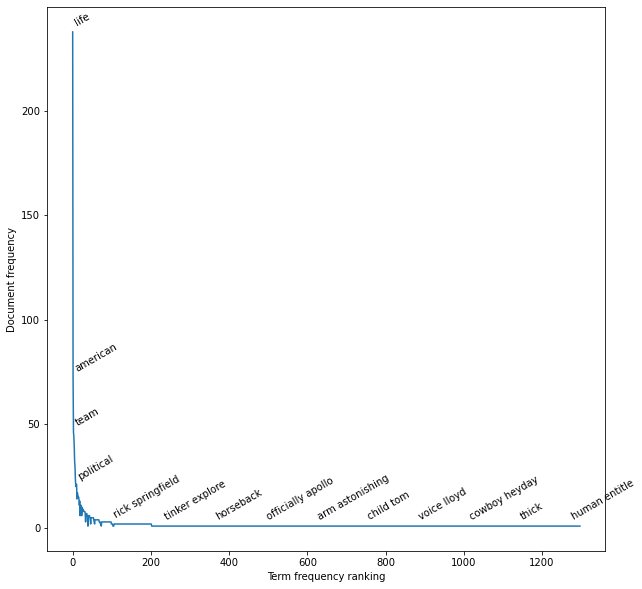

In [51]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    plt.figure(figsize=(10,10)) 
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

In [52]:

filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.7)
X_filter = filter_vec.fit_transform(df['Description'])

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names_out()))

9759


In [53]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=20, random_state=rs).fit(X_filter)

CPU times: total: 5.83 s
Wall time: 508 ms


In [54]:
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names_out())

Top terms for cluster 0: find, family, dead, dinner, guest, 
Top terms for cluster 1: life, paul, create, artist, story, 
Top terms for cluster 2: prince, tale, girl, cross, make, 
Top terms for cluster 3: life, michael, find, family, dog, 
Top terms for cluster 4: american, war, nation, soldier, offer, 
Top terms for cluster 5: get, drama, close, basketball, woman, 
Top terms for cluster 6: kid, school, parent, find, donald, 
Top terms for cluster 7: robot, science fiction, fiction, science, planet, 
Top terms for cluster 8: christmas, santa, holiday, child, claus, 
Top terms for cluster 9: herbie, city, disney, human, adventure, 
Top terms for cluster 10: documentary, interview, social, form, footage, 
Top terms for cluster 11: song, war, band, america, c, 
Top terms for cluster 12: family, day, job, new, tom, 
Top terms for cluster 13: r, winner, witch, academy award, academy, 
Top terms for cluster 14: john, father, life, new, time, 
Top terms for cluster 15: harry, potter, harry p

In [55]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3000, random_state=42)
X_trans = svd.fit_transform(X_filter)

In [56]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names_out()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 life, love, family, year, new, 
Top terms in component #1 documentary, c, footage, interview, history, 
Top terms in component #2 earth, alien, planet, save, adventure, 
Top terms in component #3 christmas, santa, holiday, best, award, 
Top terms in component #4 christmas, life, holiday, santa, town, 
Top terms in component #5 family, boy, story, adventure, school, 
Top terms in component #6 life, award, academy award, academy, best, 
Top terms in component #7 love, story, christmas, war, fall, 
Top terms in component #8 city, voice, prince, harry, disney, 
Top terms in component #9 harry, best, potter, school, harry potter, 


In [57]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=20, random_state=rs).fit(X_trans)

CPU times: total: 3.06 s
Wall time: 344 ms


In [58]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names_out())

Top terms for cluster 0: find, family, dead, dinner, guest, 
Top terms for cluster 1: life, paul, create, artist, story, 
Top terms for cluster 2: prince, tale, girl, cross, make, 
Top terms for cluster 3: life, michael, find, family, dog, 
Top terms for cluster 4: american, war, nation, soldier, offer, 
Top terms for cluster 5: get, drama, close, basketball, woman, 
Top terms for cluster 6: kid, school, parent, find, donald, 
Top terms for cluster 7: robot, science fiction, fiction, science, planet, 
Top terms for cluster 8: christmas, santa, holiday, child, claus, 
Top terms for cluster 9: herbie, city, disney, human, adventure, 
Top terms for cluster 10: documentary, interview, social, form, footage, 
Top terms for cluster 11: song, war, band, america, c, 
Top terms for cluster 12: family, day, job, new, tom, 
Top terms for cluster 13: r, winner, witch, academy award, academy, 
Top terms for cluster 14: john, father, life, new, time, 
Top terms for cluster 15: harry, potter, harry p

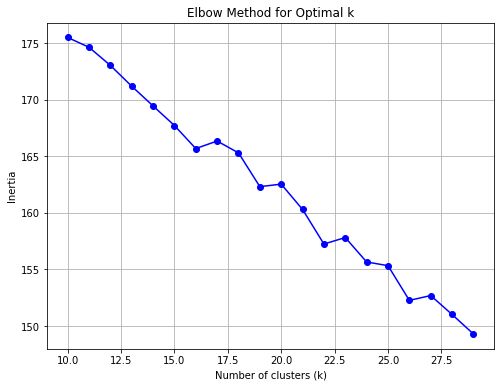

In [22]:
inertia = []
for k in range(10, 30):
    svd_kmeans = KMeans(n_clusters=k, random_state=rs).fit(X_trans)
    inertia.append(svd_kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(10, 30), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()